#########################################################################

CBPF 2021.2
Big Data e Astroinformática
Profº Clécio de Bom

Aluno Eldues Oliveira Martins 

#########################################################################
# Seismic Analysis with Python


1) Importing Libraries

In [14]:
# Importing Libraries
import numpy as np
from scipy import ndimage as ndi
from shutil import copyfile
from skimage import exposure
!pip install segyio
import segyio
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import csv
from matplotlib.offsetbox import AnchoredText




In [15]:
#Data no Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [16]:
#import segyio ## JA FORAM IMPORTADOS NO INICIO
#import numpy as np ## JA FORAM IMPORTADOS NO INICIO
#Data uploaded
with segyio.open('SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy','r+') as f:
    for trace in f.trace:
        filtered = trace[np.where(trace < 1e-2)]


2) Loading Data

In [17]:
import sys
import os


In [18]:
# Set the default plot size for matplotlib figures
matplotlib.rcParams['figure.figsize'] = (11.75,8.5)

In [19]:
base_segy = 'SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy'

In [20]:
f = segyio.open(base_segy,ignore_geometry=True)
segyio.tools.wrap(f.text[0])

'C 1  Client: SEAM Corp.     Vendor: AGT                     Date: 14 Oct 2014\nC 2  Project Description: SEAM Phase I Interpretation Challenge\nC 3  SEGY Data Format: IBM Real                            XY Units: Meters\nC 4  Data Description: 2793 Full Azimuth Shot Records with Free Surface\nC 5  Data Type: RTM Migration with Perturbed Vp and Noise in depth   Units: m\nC 6             Sparse collection of 2D offset gathers in depth\nC 7\nC 8  Projection: UTM Zone 16                Spheroid: WGS84\nC 9  Geodetic Datum: WGS84                  Central Meridian: 87 degrees W\nC10  Grid Origin XY: 401,674.66E 3,097,605.23N   Scale Factor: .9996\nC11  Grid Origin Lat Long: 28:00:00N  88:00:00W\nC12\nC13  Corner     X        Y     Iline  Xline   Given in Local Coordinates     K\nC14    1       2940    24000   1589   5801\nC15    2      31740    24000   7349   5801    Number of gathers: 33\nC16\nC17  Distance between gather X locations:  900 meters\nC18\nC19  Inline bin size:      5 m       

In [21]:
f.trace[10]
f.trace[-2]

array([-2.01366043e+00, -6.05375385e+00, -3.78104305e+00, -8.63110006e-01,
        6.11716866e-01, -1.63687706e+00, -2.72039413e+00, -1.14763451e+00,
        3.35989475e+00,  4.76012993e+00,  3.01636696e+00,  1.83521557e+00,
        2.65846252e+00, -1.27267742e+00, -3.69801140e+00,  8.05239201e-01,
        4.53335667e+00, -1.65886497e+00, -6.33541203e+00,  8.70620906e-01,
        7.55232525e+00,  4.12557602e+00,  5.89431465e-01,  5.17095290e-02,
       -4.96521854e+00, -1.07247038e+01, -7.67143345e+00,  2.50645256e+00,
        1.10698195e+01,  1.00203018e+01,  9.17518139e-01, -8.90377998e+00,
       -9.49874973e+00,  1.43924522e+00,  8.84746647e+00,  2.81741047e+00,
       -8.42773628e+00, -6.76858616e+00,  3.82758808e+00,  1.22012606e+01,
        9.46120262e+00, -8.98574948e-01, -7.73301506e+00, -7.93793106e+00,
       -1.43096924e+00,  4.90565586e+00,  3.15968513e+00,  9.93162572e-01,
        1.53293324e+00,  2.92832184e+00,  2.60410786e+00, -7.50936151e-01,
       -4.47587109e+00, -

In [22]:
f.samples[:5]

array([ 0., 20., 40., 60., 80.])

In [23]:
with segyio.open(base_segy) as segyf:
    n_traces = segyf.tracecount
    sample_rate = segyio.tools.dt(segyf)
    n_samples = segyf.samples.size
    n_il = len(segyf.iline)

In [24]:
f = segyio.open(base_segy, ignore_geometry = True)
ntraces    = len(f.trace)
inlines    = []
crosslines = []

for i in range(ntraces):
    headeri = f.header[i]
    inlines.append(headeri[segyio.su.iline])
    crosslines.append(headeri[segyio.su.xline])

print(f'{ntraces} traces')
print(f'first 10 inlines: {inlines[:10]}')
print(f'first 10 crosslines: {crosslines[:10]}')


990 traces
first 10 inlines: [1589, 1589, 1589, 1589, 1589, 1589, 1589, 1589, 1589, 1589]
first 10 crosslines: [5801, 5801, 5801, 5801, 5801, 5801, 5801, 5801, 5801, 5801]


In [25]:
# loading the seismic data as cube
seismic_data = segyio.tools.cube(base_segy)

In [26]:
# lets check the inline, xline spread of the seismic data
print('Survey IL/XL shape:' +str(np.shape(seismic_data)[0])+ ' / ' +str(np.shape(seismic_data)[1]))

Survey IL/XL shape:1 / 33


In [27]:
#Check the inline e cross line range for the seismic data directly from segy file is below
print('Inline Range:' +str(np.amin(segyf.ilines))+'-'+str(np.amax(segyf.ilines)))
print('Xnline Range:' +str(np.amin(segyf.xlines))+'-'+str(np.amax(segyf.xlines)))

Inline Range:1589-7349
Xnline Range:5801-5801


In [28]:
# Plot the inline and crossline as a scatter plot
#plt.scatter(crosslines, inlines, marker="s", s=1)

In [29]:
import itertools
uniqil = set(inlines)
uniqxl = set(crosslines)
real = set(zip(inlines, crosslines))
grid = set(itertools.product(uniqil, uniqxl))
missing = grid - real
missing

set()

In [30]:
#plt.plot(inlines)

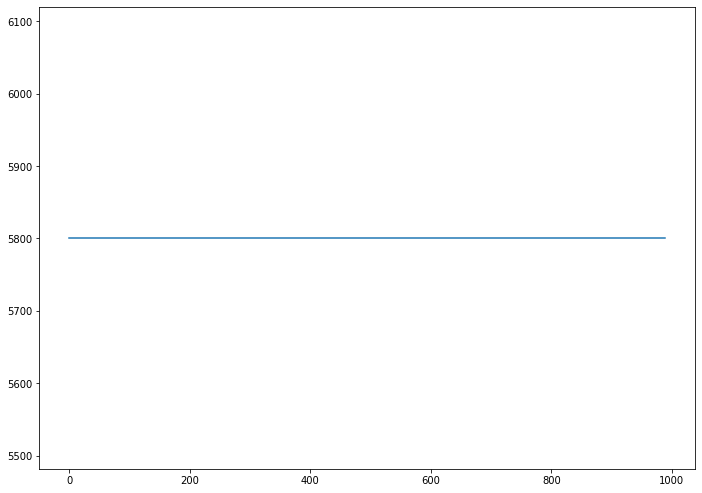

In [31]:
plt.plot(crosslines[:5000])

In [32]:
# NAO ESTA FUNCIONANDO DADOS ESTRUTURADO
#f.header[5]={segyio.su.tracl: 10}
#f.header[5].items()
#f.header[5][25, 37] # read multiple values at once


In [33]:
#import numpy as np
ils = np.unique(inlines)
xls = np.unique(crosslines)
inline_interval    = ils[1:] - ils[:-1]
crossline_interval = xls[1:] - xls[:-1]
print(inline_interval)
print(crossline_interval)

[180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180]
[]


In [34]:
ils = sorted(uniqil)
xls = sorted(uniqxl)
lineindex = {
    (il, xl): i
    for i, (il, xl) in enumerate(sorted(grid))

}
lineindex

{(1589, 5801): 0,
 (1769, 5801): 1,
 (1949, 5801): 2,
 (2129, 5801): 3,
 (2309, 5801): 4,
 (2489, 5801): 5,
 (2669, 5801): 6,
 (2849, 5801): 7,
 (3029, 5801): 8,
 (3209, 5801): 9,
 (3389, 5801): 10,
 (3569, 5801): 11,
 (3749, 5801): 12,
 (3929, 5801): 13,
 (4109, 5801): 14,
 (4289, 5801): 15,
 (4469, 5801): 16,
 (4649, 5801): 17,
 (4829, 5801): 18,
 (5009, 5801): 19,
 (5189, 5801): 20,
 (5369, 5801): 21,
 (5549, 5801): 22,
 (5729, 5801): 23,
 (5909, 5801): 24,
 (6089, 5801): 25,
 (6269, 5801): 26,
 (6449, 5801): 27,
 (6629, 5801): 28,
 (6809, 5801): 29,
 (6989, 5801): 30,
 (7169, 5801): 31,
 (7349, 5801): 32}

In [35]:
d = np.zeros((len(ils), len(xls), len(f.samples)))
lineard = d.reshape(d.shape[0] * d.shape[1], d.shape[2])
for il, xl, trace in zip(inlines, crosslines, f.trace[:]):
    lineard[lineindex[il, xl]][:] = trace[:]

In [36]:
d.shape

(33, 1, 751)

In [37]:
# Set up some aliases
ilines = np.array(sorted(uniqil))
xlines = np.array(sorted(uniqxl))
t = np.array(f.samples)

# Estimate the amplitude range to use for the plots by taking the 95th percentile

vm = np.percentile(d, 95)
print(vm)

# Define the central line
central = len(ilines) // 2

19.057722473144516


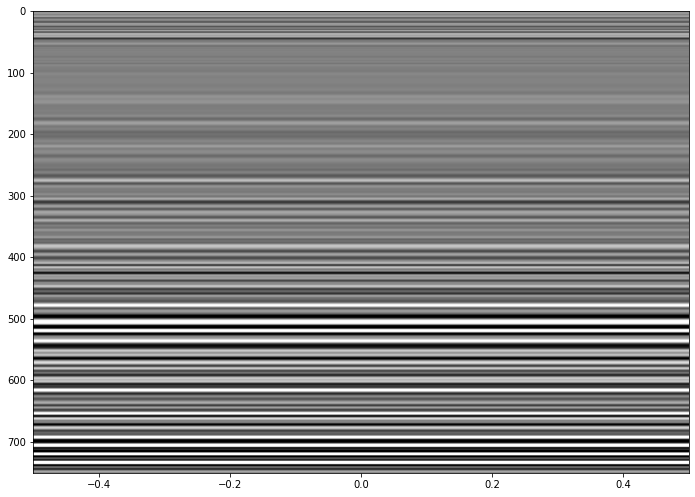

In [38]:
# Plot

plt.imshow(d[central,:,:].T, cmap='gray', aspect='auto', vmin=-vm, vmax=vm)
plt.show()

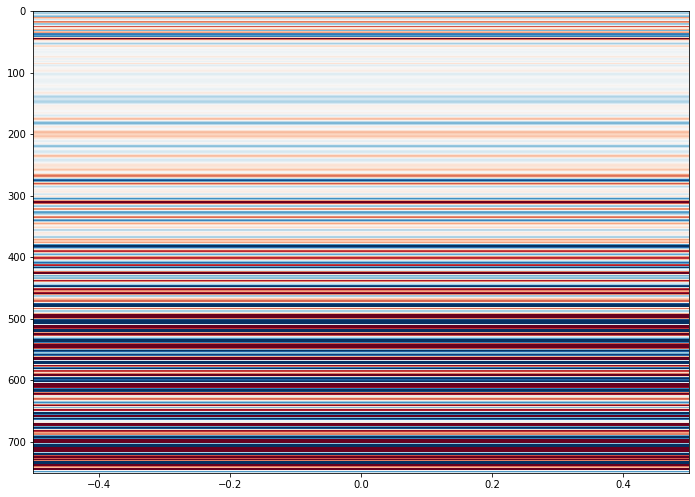

In [39]:
# Plot paleta
#plt.imshow(d[central,:,:].T, cmap='RdBu',aspect='auto',vmin=-vm, vmax=vm)
plt.imshow(d[central,:,:].T, cmap='RdBu',aspect='auto', vmin=-10, vmax=10)
plt.show()

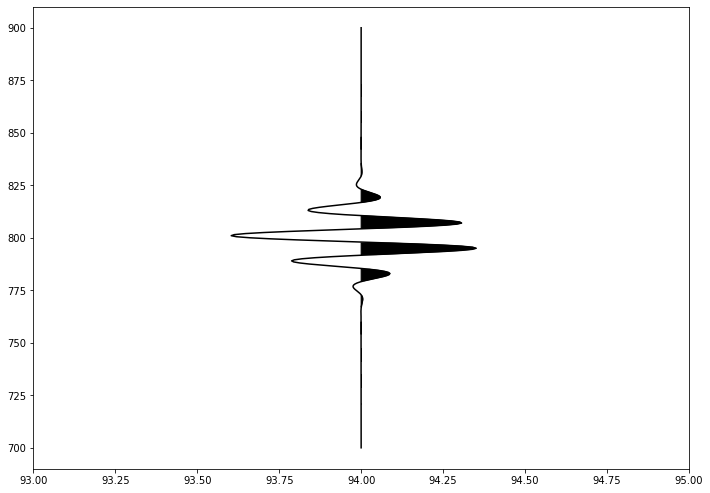

In [40]:
fig,ax = plt.subplots()

# Some example data
y = np.linspace(700.,900.,401)
offset = 94.
x = offset+10*(np.sin(y/2.)*
        1/(10. * np.sqrt(2 * np.pi)) *
        np.exp( - (y - 800)**2 / (2 * 10.**2))
        ) # This function just gives a wave that looks something like a seismic arrival

ax.plot(x,y,'k-')
ax.fill_betweenx(y,offset,x,where=(x>offset),color='k')

ax.set_xlim(93,95)

plt.show()

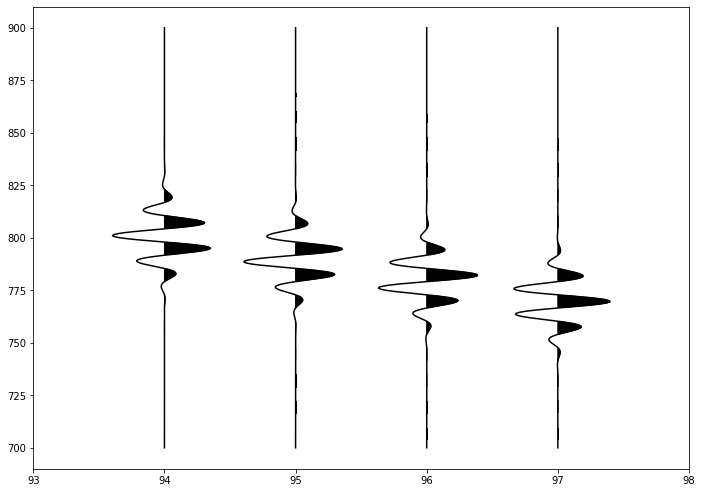

In [41]:
fig,ax = plt.subplots()

# Some example data
y = np.linspace(700.,900.,401)
offsets = [94., 95., 96., 97.]
times = [800., 790., 780., 770.]

for offset, time in zip(offsets,times):
    x = offset+10*(np.sin(y/2.)*
        1/(10. * np.sqrt(2 * np.pi)) *
        np.exp( - (y - time)**2 / (2 * 10.**2))
        )

    ax.plot(x,y,'k-')
    ax.fill_betweenx(y,offset,x,where=(x>offset),color='k')

ax.set_xlim(93,98)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical left == right == 5801 results in singular transformations; automatically expanding.
  """


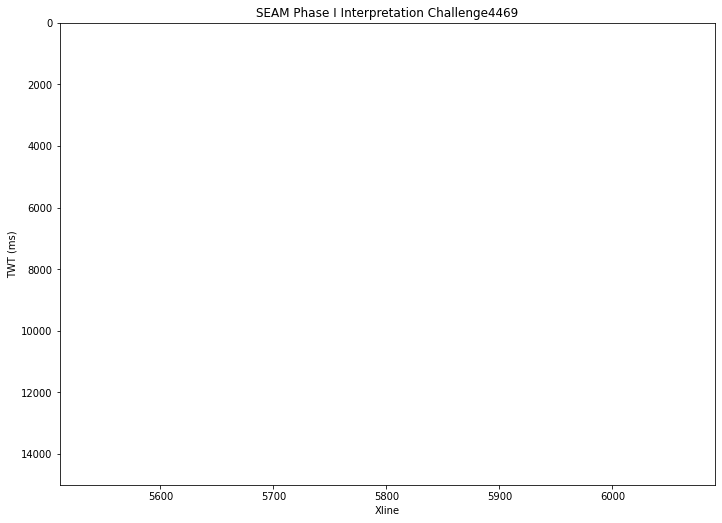

In [42]:
extent = [xlines[0], xlines[-1], t[-1], t[0]]

# Plot the central inline in the usual orientation by transposing the data

plt.imshow(d[central,:,:].T, cmap='gray', aspect='auto', vmin=-vm, vmax=vm, extent=extent)

plt.xlabel('Xline')
plt.ylabel('TWT (ms)')
plt.title('SEAM Phase I Interpretation Challenge'+ str(ilines[central]))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Attempting to set identical left == right == 5801 results in singular transformations; automatically expanding.
  import sys


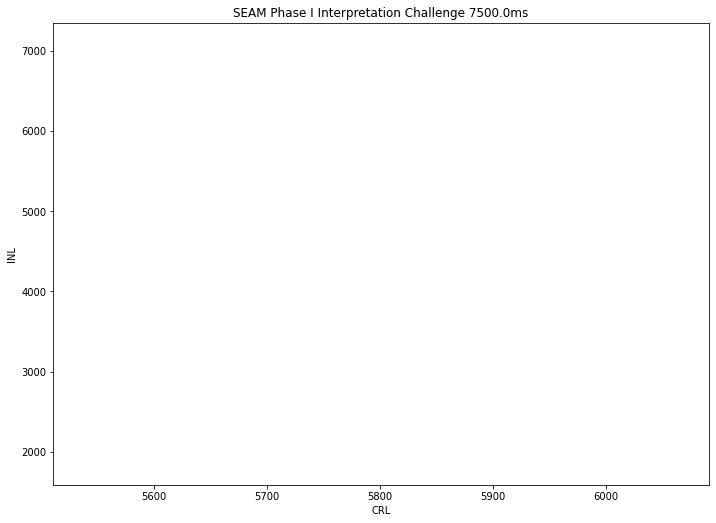

In [43]:
# Central time slice

tmid = len(t)//2

extent = [xlines[0], xlines[-1], ilines[0], ilines[-1]]

plt.imshow(d[:,:,tmid], cmap='gray', origin='lower', aspect='auto', vmin=-vm, vmax=vm, extent=extent)

plt.xlabel('CRL')
plt.ylabel('INL')
plt.title('SEAM Phase I Interpretation Challenge '+ str(t[tmid])+'ms')
plt.show()

In [44]:
import xarray as xr
!pip install hvplot
import panel as pn

     |████████████████████████████████| 3.1 MB 5.2 MB/s 


In [45]:
# Define a plotting function, the input will be the inline

def plot_inl(inl):
    """
    Plot a single inline using hvplot
    """
    idx = inl - ilines[0]
    da = xr.DataArray(d[idx,:,:].T)    
    p = da.hvplot.image(clim=(-vm, vm), cmap='gray', flip_yaxis=True) 
    return p

Controle de Qualidade para dados 3D

In [46]:
# Restore in 3D Data
#plot_inl(ilines[central])

In [47]:
# Restore in 3D Data
# Use panel to pass an array of ilines to the function

#pn.interact(plot_inl, inl = ilines)

In [48]:
# Restore in 3D Data
#line_select = pn.widgets.Select(name='INL Selection', options=ilines.tolist())

#pn.interact(plot_inl, inl = line_select)

In [49]:
##Create a Data Array
#da = xr.DataArray(data = d,
#                  dims = ['il','xl','twt'],
#                  coords = {'il': ilines,
#                          'xl': xlines,
#                          'twt': t})
## Take a look
#da
#da.sel(twt = 3000)
#da[:,:,749]
## To select a range we use slice
#da.sel(twt = slice(2000,3000))
## Add some attribute information to the datarray
#da.attrs['Year'] = '2002'
#da.attrs['Type'] = 'Final PSDM time converted'

## Create a dataset
#volve_ds = da.to_dataset(name = 'base')

## Add some attribute information to the dataset
#volve_ds.attrs['Country'] = 'Norway'
#volve_ds.attrs['Field'] = 'Volve'

## Take a look
#volve_ds
## Extract a line from the base survey
#volve_ds['base'].sel(il = 9963)

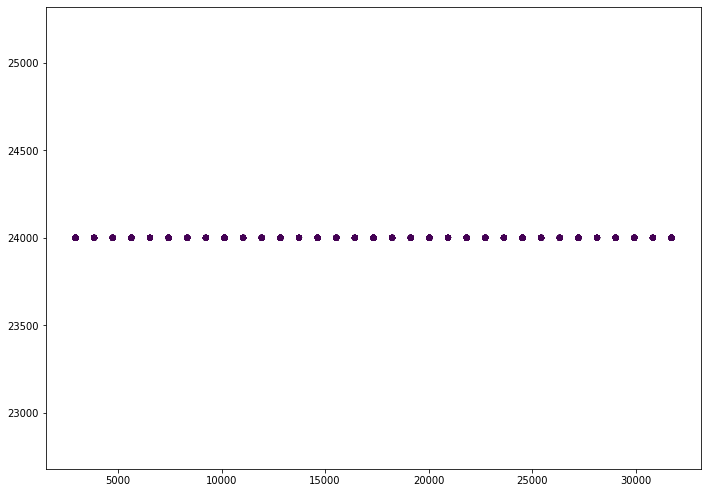

In [50]:
filename = 'SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy'
with segyio.open(filename, ignore_geometry=True) as segyfile:
    segyfile.mmap()

    # Extract header word for all traces
    sourceX = segyfile.attributes(segyio.TraceField.SourceX)[:]

    # Scatter plot sources and receivers color-coded on their number
    plt.figure()
    sourceY = segyfile.attributes(segyio.TraceField.SourceY)[:]
    nsum = segyfile.attributes(segyio.TraceField.NSummedTraces)[:]
    plt.scatter(sourceX, sourceY, c=nsum, edgecolor='none')

    groupX = segyfile.attributes(segyio.TraceField.GroupX)[:]
    groupY = segyfile.attributes(segyio.TraceField.GroupY)[:]
    nstack = segyfile.attributes(segyio.TraceField.NStackedTraces)[:]
    plt.scatter(groupX, groupY, c=nstack, edgecolor='none')


2) Data Preprocessing

In [51]:
def main():
    filename = 'SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy'

    # Open file
    with segyio.open(filename, ignore_geometry=True) as f:
    # Get all header keys:
        header_keys = segyio.tracefield.keys
        # Initialize df with trace id as index and headers as columns
        trace_headers = pd.DataFrame(index=range(1, f.tracecount+1),
                                 columns=header_keys.keys())
        # Fill dataframe with all trace headers values
        for k, v in header_keys.items():
            trace_headers[k] = f.attributes(v)[:]
    print(trace_headers.head())
    trace_headers.to_csv('out.csv')
if __name__ == '__main__':
    main()

   TRACE_SEQUENCE_LINE  TRACE_SEQUENCE_FILE  ...  UnassignedInt1  UnassignedInt2
1                    0                    0  ...               0               0
2                    0                    0  ...               0               0
3                    0                    0  ...               0               0
4                    0                    0  ...               0               0
5                    0                    0  ...               0               0

[5 rows x 91 columns]


In [52]:
pd.read_csv('out.csv')


,Unnamed: 0,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,DataUse,offset,ReceiverGroupElevation,SourceSurfaceElevation,SourceDepth,ReceiverDatumElevation,SourceDatumElevation,SourceWaterDepth,GroupWaterDepth,ElevationScalar,SourceGroupScalar,SourceX,SourceY,GroupX,GroupY,CoordinateUnits,WeatheringVelocity,SubWeatheringVelocity,SourceUpholeTime,GroupUpholeTime,SourceStaticCorrection,GroupStaticCorrection,TotalStaticApplied,LagTimeA,LagTimeB,DelayRecordingTime,MuteTimeStart,MuteTimeEND,TRACE_SAMPLE_COUNT,...,AliasFilterFrequency,AliasFilterSlope,NotchFilterFrequency,NotchFilterSlope,LowCutFrequency,HighCutFrequency,LowCutSlope,HighCutSlope,YearDataRecorded,DayOfYear,HourOfDay,MinuteOfHour,SecondOfMinute,TimeBaseCode,TraceWeightingFactor,GeophoneGroupNumberRoll1,GeophoneGroupNumberFirstTraceOrigField,GeophoneGroupNumberLastTraceOrigField,GapSize,OverTravel,CDP_X,CDP_Y,INLINE_3D,CROSSLINE_3D,ShotPoint,ShotPointScalar,TraceValueMeasurementUnit,TransductionConstantMantissa,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2
0,1,0,0,0,0,1589,5801,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,2940,24000,2940,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2940,24000,1589,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1589,5801,0,1,0,0,0,400,0,0,0,0,0,0,0,1,1,2940,24000,2940,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2940,24000,1589,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1589,5801,0,1,0,0,0,800,0,0,0,0,0,0,0,1,1,2940,24000,2940,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2940,24000,1589,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,1589,5801,0,1,0,0,0,1200,0,0,0,0,0,0,0,1,1,2940,24000,2940,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2940,24000,1589,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1589,5801,0,1,0,0,0,1600,0,0,0,0,0,0,0,1,1,2940,24000,2940,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2940,24000,1589,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,986,0,0,0,0,7349,5801,0,1,0,0,0,10000,0,0,0,0,0,0,0,1,1,31740,24000,31740,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31740,24000,7349,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
986,987,0,0,0,0,7349,5801,0,1,0,0,0,10400,0,0,0,0,0,0,0,1,1,31740,24000,31740,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31740,24000,7349,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
987,988,0,0,0,0,7349,5801,0,1,0,0,0,10800,0,0,0,0,0,0,0,1,1,31740,24000,31740,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31740,24000,7349,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
988,989,0,0,0,0,7349,5801,0,1,0,0,0,11200,0,0,0,0,0,0,0,1,1,31740,24000,31740,24000,0,0,0,0,0,0,0,0,0,0,0,0,0,751,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31740,24000,7349,5801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


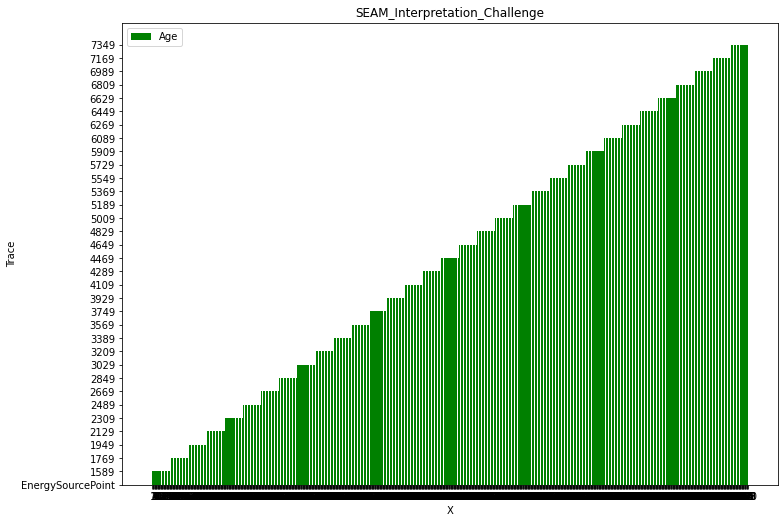

In [63]:
import matplotlib.pyplot as plt
import csv
  
x = []
y = []
  
with open('out.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
      
    for row in plots:
        x.append(row[0])
        y.append(row[5])
  
plt.bar(x, y, color = 'g', width = 0.72, label = "Age")
plt.xlabel('x')
plt.ylabel('Trace')
plt.title('SEAM_Interpretation_Challenge')
plt.legend()
plt.show()